## Predicted Masks of Images

This notebook shows 5-10 samples predicted segmentation masks with their corresponding input image and ground truth annotation mask.

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
from math import ceil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, BatchNormalization, Dropout, Conv2DTranspose, concatenate, Add


from tensorflow import keras

from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH_TO_PROJECT = 'gdrive/Shareddrives/Segmentation Project/'

In [ ]:
# Load dataframes
normal_df = pd.read_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','normal_df.csv'))
covid_df = pd.read_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','covid_df.csv'))
pneumonia_df = pd.read_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','pneumonia_df.csv'))
other_df = pd.read_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','other_df.csv'))
combined_df = pd.concat([normal_df, covid_df, pneumonia_df, other_df], axis=0, ignore_index=True)

In [ ]:
'''
Function to...

Parameters:
  ...
Returns...
'''
def process_load_generator(X,y,batch_size=32,target_size=256):
  # Transforms and augmentations
  idg = ImageDataGenerator(rescale=1.0/(target_size-1))
  # rotation_range=20,
  # horizontal_flip=True,

  # something
  ig = idg.flow_from_dataframe(
    dataframe=X,
    x_col='PATH_IMAGE',
    y_col=None,  # Set to None if there are no labels
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode=None,  # Set to None since there are no labels
    color_mode='rgb',
    shuffle=False,
    seed=42
  )
  # something
  mg = idg.flow_from_dataframe(
    dataframe=y.to_frame(),
    x_col='PATH_MASK',
    y_col=None,  # Set to None if there are no labels
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode=None,  # Set to None since there are no labels
    color_mode='grayscale',
    shuffle=False,
    seed=42
  )
  # Yield zipped images and masks
  # for (imgs, msks) in zip(ig, mg):
  #   yield imgs, msks
  return zip(ig, mg)

In [ ]:
# First Divide data in half
X_train, X_test, y_train, y_test = train_test_split(combined_df[['PATH_IMAGE','PATH_MASK','CLASS']], combined_df['PATH_MASK'], test_size=0.5, random_state=42, stratify = combined_df['CLASS'].tolist())
# Subsequently, divide test set again
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42, stratify = X_test['CLASS'].tolist())
# View counts/proportions
print(f'Counts:\nTrain: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}')
print(f'Proportions:\nTrain: {len(y_train)/combined_df.shape[0]:.3f}, Val: {len(y_val)/combined_df.shape[0]:.3f}, Test: {len(y_test)/combined_df.shape[0]:.3f}')

Counts:
Train: 3175, Val: 1270, Test: 1906
Proportions:
Train: 0.500, Val: 0.200, Test: 0.300


In [ ]:
X_train

,PATH_IMAGE,PATH_MASK,CLASS
3176,gdrive/Shareddrives/Segmentation Project/COVID...,gdrive/Shareddrives/Segmentation Project/COVID...,COVID
223,gdrive/Shareddrives/Segmentation Project/COVID...,gdrive/Shareddrives/Segmentation Project/COVID...,Normal
3680,gdrive/Shareddrives/Segmentation Project/COVID...,gdrive/Shareddrives/Segmentation Project/COVID...,COVID
2568,gdrive/Shareddrives/Segmentation Project/COVID...,gdrive/Shareddrives/Segmentation Project/COVID...,Normal
1291,gdrive/Shareddrives/Segmentation Project/COVID...,gdrive/Shareddrives/Segmentation Project/COVID...,Normal
...,...,...,...
5559,gdrive/Shareddrives/Segmentation Project/COVID...,gdrive/Shareddrives/Segmentation Project/COVID...,Lung_Opacity
415,gdrive/Shareddrives/Segmentation Project/COVID...,gdrive/Shareddrives/Segmentation Project/COVID...,Normal
1652,gdrive/Shareddrives/Segmentation Project/COVID...,gdrive/Shareddrives/Segmentation Project/COVID...,Normal
974,gdrive/Shareddrives/Segmentation Project/COVID...,gdrive/Shareddrives/Segmentation Project/COVID...,Normal


Set model of same articheture for import

In [ ]:
def double_conv_block(x, filters):
  '''
  ResUNet helper function: Performs a double convolutional layer
  + batch normalisation operation on inputs, with n filters.

  Parameters:
      x (tensor): Input data
      filters (int): Number of filters/convolutions to be applied
  Returns:
      x (tensor): Output feature map after double convolution block
  '''
  # Conv2D layer
  x = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Batch normalisation
  x = BatchNormalization()(x)
  # Conv2D layer
  x = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Batch normalisation
  x = BatchNormalization()(x)
  # Return activations
  return x

def downsample_block(x, filters):
  '''
  ResUNet helper function: Performs a downsampling block, as
  described in the report.

  Parameters:
      x (tensor): Input data
      filters (int): Number of filters/convolutions to be applied
  Returns:
      long_residual (tensor): Output feature map after double convolution block
      downsample (tensor): Output feature map after double convolution block
  '''
  # Skip connection
  res = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Double conv block
  x = double_conv_block(x, filters)
  # Add skip connection to double conv output
  long_residual = Add()([x, res])
  # Downsample using pooling
  downsample = MaxPool2D(2)(long_residual)
  # Apply regularisation
  downsample = Dropout(0.3)(downsample)
  # Return long residual, pooling
  return long_residual, downsample

def upsample_block(x, long_residual, filters):
  '''
  ResUNet helper function:  Performs a upsampling block, as
  described in the report.
  '''
  # Upsample: transpose =(mathematically equivalent)= upsample + 2*2 conv
  x = Conv2DTranspose(filters, 3, 2, padding="same")(x)
  # Long residual connection (original UNet)
  x = concatenate([x, long_residual])
  # Short residual connection (ResUNet) - after upsampling, before double conv
  res = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Double conv block
  x = double_conv_block(x, filters)
  # Add skip connection to double conv output
  upsample = Add()([x, res])
  # Apply regularisation
  upsample = Dropout(0.3)(upsample)
  # Return activations
  return upsample

def ResUNet(image_size):
  '''
  ResUNet definition, as outlined in report.

  Parameters:

  '''
  # Read input
  inputs = Input(shape=(image_size,image_size,3))
  ## Down-sampling
  long_residual_1, downsample_1 = downsample_block(inputs, 64)
  long_residual_2, downsample_2 = downsample_block(downsample_1, 128)
  long_residual_3, downsample_3 = downsample_block(downsample_2, 256)
  long_residual_4, downsample_4 = downsample_block(downsample_3, 512)
  ## Bridge or bottleneck
  # Double conv
  bottleneck = double_conv_block(downsample_4, 1024)
  # Calculate residual
  residual = Conv2D(1024, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(downsample_4)
  # Add residual to bottleneck
  bottleneck_residual = Add()([bottleneck, residual])
  ## Up-sampling
  upsample1 = upsample_block(bottleneck_residual, long_residual_4, 512)
  upsample2 = upsample_block(upsample1, long_residual_3, 256)
  upsample3 = upsample_block(upsample2, long_residual_2, 128)
  upsample4 = upsample_block(upsample3, long_residual_1, 64)

  # Output layer
  outputs = Conv2D(1, 3, padding="same", activation = "sigmoid")(upsample4)
  # Build model
  resUNet_model = tf.keras.Model(inputs, outputs, name = 'ResUNet')

  # Return built model
  return resUNet_model

In [ ]:
resUNet_model = ResUNet(256)
resUNet_model.load_weights('/content/gdrive/Shareddrives/Segmentation Project/Notebooks/model_weights/ResUNet_weights.h5')

Import DeCovNet

In [ ]:
def pool_conv_block(x, filters):
  '''
  DeConvNet helper function: Performs a single convolutional layer
  + batch normalisation operation + max pooling on inputs, with n filters.

  Parameters:
      x (tensor): Input data.
      filters (int): Number of filters/convolutions to be applied.
  Returns:
      x (tensor): Output feature map after pooling
  '''
  # Conv2D layer
  x = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Batch normalisation
  x = BatchNormalization()(x)
  # Max pooling
  x = MaxPool2D(2)(x)
  # Regularisation
  x = Dropout(0.3)(x)
  # Return activations
  return x

def depool_conv_block(x, filters):
  '''
  DeConvNet helper function: Unpools and performs convolution +
  batch normalisation

  Parameters:
      x (tensor): Input data.
      filters (int): Number of filters/convolutions to be applied.
  Returns:
      x (tensor): Output feature map after depooling
  '''
  # Depool
  x = Conv2DTranspose(filters, 3, 2, padding="same")(x)
  # Conv2D layer
  x = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Batch normalisation
  x = BatchNormalization()(x)
  # Regularisation
  x = Dropout(0.3)(x)
  # Return activations
  return x

def DeConvNet(image_size):
  '''
  DeConvNet definition, as outlined in report.

  Parameters:
    image_size (int): Size of input image.
  Returns:
    deConvNet_model (tf.keras.Model): Built Tensorflow Keras model.

  '''
  ## Read input
  inputs = Input(shape=(image_size,image_size,3))
  ## Pooling - Based on VGG16
  # Pooling, conv blocks
  x = pool_conv_block(inputs, 64)
  x = pool_conv_block(x, 128)
  x = pool_conv_block(x, 256)
  x = pool_conv_block(x, 512)
  x = pool_conv_block(x, 512)
  # Intermediate "dense layers"
  x = Conv2D(512, 1, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  x = Conv2D(512, 1, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Depool, conv blocks
  x = depool_conv_block(x, 512)
  x = depool_conv_block(x, 512)
  x = depool_conv_block(x, 256)
  x = depool_conv_block(x, 128)
  x = depool_conv_block(x, 64)
  ## Output block
  outputs = Conv2D(1, 3, padding="same", activation = "sigmoid")(x)
  ## Build model
  deConvNet_model = tf.keras.Model(inputs, outputs, name = 'DeConvNet')
  # Return model
  return deConvNet_model

In [ ]:
deConvNet_model = DeConvNet(256)
deConvNet_model.load_weights('/content/gdrive/Shareddrives/Segmentation Project/Notebooks/model_weights/DeConvNet_weights.h5')

Run Seqmentation masking

1/1 [==============================] - 1s 1s/step


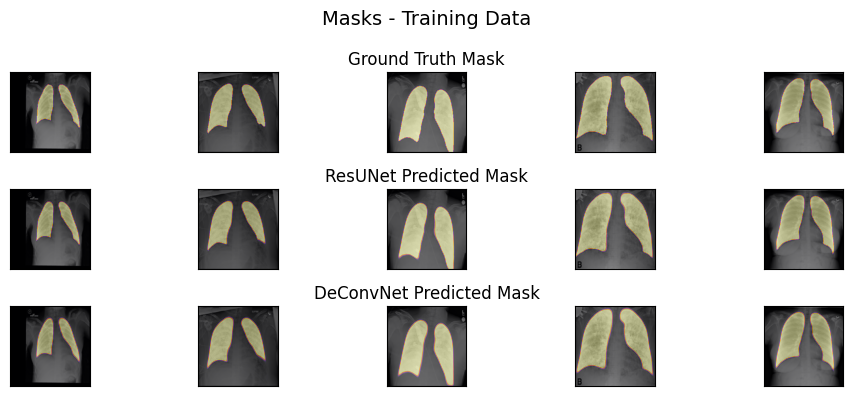

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(10, 4))
fig.suptitle('Masks - Training Data', fontsize=14)
axes[0, 2].set_title('Ground Truth Mask')
axes[1, 2].set_title('ResUNet Predicted Mask')
axes[2, 2].set_title('DeConvNet Predicted Mask')
randomintlist = []
for i in range(0,5):
  randindex = np.random.randint(0, X_train.shape[0]-1)
  randomintlist.append(randindex)


for j in range(5):
    # Select a random column index
    random_index = randomintlist[j]

    # Get the selected column name
    vis_img = plt.imread(X_train.iloc[random_index]['PATH_IMAGE'])
    vis_mask = plt.imread(X_train.iloc[random_index]['PATH_MASK'])
    vis_img = cv2.resize(vis_img, (256,256))

    axes[0,j].imshow(vis_img, cmap = 'gray')
    axes[0,j].imshow(vis_mask[:,:,0], cmap = 'inferno', alpha=0.5)

    axes[0, j].set_xticks([])
    axes[0, j].set_yticks([])


    # Get the selected column name
    vis_img = tf.expand_dims(img_to_array(load_img(X_train.iloc[random_index]['PATH_IMAGE'], target_size=(256, 256))),0)/255
    vis_img_pred_mask = resUNet_model.predict(vis_img)

    axes[1,j].imshow(vis_img[0], cmap = 'gray')
    axes[1,j].imshow(vis_img_pred_mask[0], cmap = 'inferno', alpha=0.5)

    axes[1, j].set_xticks([])
    axes[1, j].set_yticks([])

    # Get the selected column name
    vis_img = tf.expand_dims(img_to_array(load_img(X_train.iloc[random_index]['PATH_IMAGE'], target_size=(256, 256))),0)/255
    vis_img_pred_mask = deConvNet_model.predict(vis_img)

    axes[2,j].imshow(vis_img[0], cmap = 'gray')
    axes[2,j].imshow(vis_img_pred_mask[0], cmap = 'inferno', alpha=0.5)

    axes[2, j].set_xticks([])
    axes[2, j].set_yticks([])

plt.tight_layout()

1/1 [==============================] - 1s 1s/step


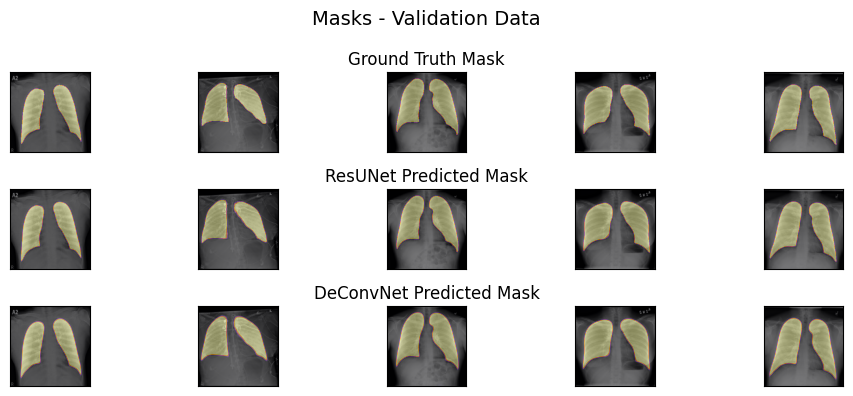

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(10, 4))
fig.suptitle('Masks - Validation Data', fontsize=14)
axes[0, 2].set_title('Ground Truth Mask')
axes[1, 2].set_title('ResUNet Predicted Mask')
axes[2, 2].set_title('DeConvNet Predicted Mask')

randomintlist = []
for i in range(0,5):
  randindex = np.random.randint(0, X_val.shape[0]-1)
  randomintlist.append(randindex)


for j in range(5):
    # Select a random column index
    random_index = randomintlist[j]

    # Get the selected column name
    vis_img = plt.imread(X_val.iloc[random_index]['PATH_IMAGE'])
    vis_mask = plt.imread(X_val.iloc[random_index]['PATH_MASK'])
    vis_img = cv2.resize(vis_img, (256,256))

    axes[0,j].imshow(vis_img, cmap = 'gray')
    axes[0,j].imshow(vis_mask[:,:,0], cmap = 'inferno', alpha=0.5)

    axes[0, j].set_xticks([])
    axes[0, j].set_yticks([])


    # Get the selected column name
    vis_img = tf.expand_dims(img_to_array(load_img(X_val.iloc[random_index]['PATH_IMAGE'], target_size=(256, 256))),0)/255
    vis_img_pred_mask = resUNet_model.predict(vis_img)

    axes[1,j].imshow(vis_img[0], cmap = 'gray')
    axes[1,j].imshow(vis_img_pred_mask[0], cmap = 'inferno', alpha=0.5)

    axes[1, j].set_xticks([])
    axes[1, j].set_yticks([])

    # Get the selected column name
    vis_img = tf.expand_dims(img_to_array(load_img(X_val.iloc[random_index]['PATH_IMAGE'], target_size=(256, 256))),0)/255
    vis_img_pred_mask = deConvNet_model.predict(vis_img)

    axes[2,j].imshow(vis_img[0], cmap = 'gray')
    axes[2,j].imshow(vis_img_pred_mask[0], cmap = 'inferno', alpha=0.5)

    axes[2, j].set_xticks([])
    axes[2, j].set_yticks([])

plt.tight_layout()

1/1 [==============================] - 1s 796ms/step


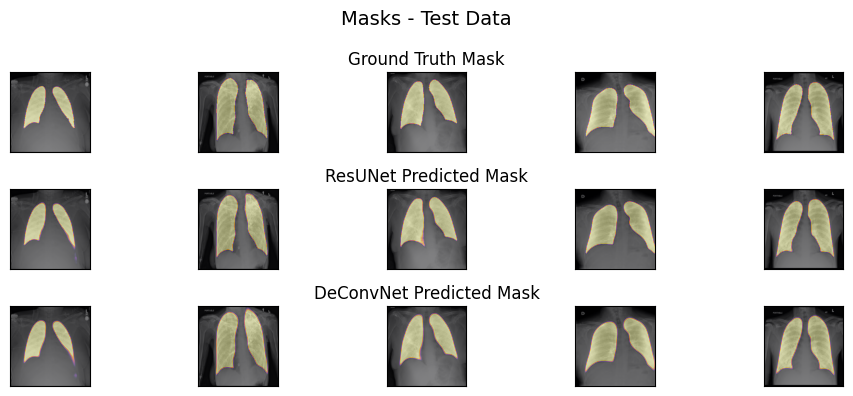

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(10, 4))
fig.suptitle('Masks - Test Data', fontsize=14)
axes[0, 2].set_title('Ground Truth Mask')
axes[1, 2].set_title('ResUNet Predicted Mask')
axes[2, 2].set_title('DeConvNet Predicted Mask')

randomintlist = []
for i in range(0,5):
  randindex = np.random.randint(0, X_test.shape[0]-1)
  randomintlist.append(randindex)


for j in range(5):
    # Select a random column index
    random_index = randomintlist[j]

    # Get the selected column name
    vis_img = plt.imread(X_test.iloc[random_index]['PATH_IMAGE'])
    vis_mask = plt.imread(X_test.iloc[random_index]['PATH_MASK'])
    vis_img = cv2.resize(vis_img, (256,256))

    axes[0,j].imshow(vis_img, cmap = 'gray')
    axes[0,j].imshow(vis_mask[:,:,0], cmap = 'inferno', alpha=0.5)

    axes[0, j].set_xticks([])
    axes[0, j].set_yticks([])


    # Get the selected column name
    vis_img = tf.expand_dims(img_to_array(load_img(X_test.iloc[random_index]['PATH_IMAGE'], target_size=(256, 256))),0)/255
    vis_img_pred_mask = resUNet_model.predict(vis_img)

    axes[1,j].imshow(vis_img[0], cmap = 'gray')
    axes[1,j].imshow(vis_img_pred_mask[0], cmap = 'inferno', alpha=0.5)

    axes[1, j].set_xticks([])
    axes[1, j].set_yticks([])

    # Get the selected column name
    vis_img = tf.expand_dims(img_to_array(load_img(X_test.iloc[random_index]['PATH_IMAGE'], target_size=(256, 256))),0)/255
    vis_img_pred_mask = deConvNet_model.predict(vis_img)

    axes[2,j].imshow(vis_img[0], cmap = 'gray')
    axes[2,j].imshow(vis_img_pred_mask[0], cmap = 'inferno', alpha=0.5)

    axes[2, j].set_xticks([])
    axes[2, j].set_yticks([])

plt.tight_layout()